Case Study
---
Do you want to buy a new laptop? If yes, what is your concern?, Price, or its equipment?

Before making the decision, let us explore the price of laptop.

To make the accurate information, 1) we will make a detailed Exploratory Data Analysis (EDA), or called data washing; 2.) create a model fpr prediction for the value of laptop; 3.) Deployment of the Model.


Skills of Pandas manipulation
---
1. `df['Memory].unique()`, set of terms in this feature;
2. `df['Memory].value_counts()`, count of each unique term in this feature;
3. `df["Memory"].str.split(pat=pattern,expand=True)`, split string into different features, by using `pattern` as the delimiter string.
4.  Extract the part of digits, where  
```
# more than one digit
pattern='(\d+)'
df['Memory'].str.extract(pattern,expand=True)
```
5. Extract the part of letters, 
```
# more than one letter, capital or not
pattern='([A-Za-z+]+)'
df['Memory'].str.extract(pattern,expand=True)
```

In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# pkg for interactive vis

import warnings
warnings.filterwarnings('ignore')
#把warning省略掉

%matplotlib inline

In [2]:
#file="https://raw.githubusercontent.com/Raghavagr/Laptop_Price_Prediction/main/laptop_data.csv"
file="Laptop_prive.csv"
df = pd.read_csv(file) 

In [4]:
# save the data
df.to_csv("Laptop_prive.csv",index=0)

In [3]:
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [5]:
# delete the useless feature
df.drop(columns=['Unnamed: 0'],inplace=True)

## remove gb and kg from Ram and weight and convert the cols to numeric
df['Ram'] = df['Ram'].str.replace("GB", "")
df['Weight'] = df['Weight'].str.replace("kg", "")
df['Ram'] = df['Ram'].astype('int32')
df['Weight'] = df['Weight'].astype('float32')

# Convert the price to NT dollar
df['Price'] = ((0.39*df['Price']//100)*100).astype('int')

# Prediction


[Regression Prediction, pycaret](#Prediction-by-Pycaret)
1. first case:
```
features=['Ram','Weight']
target='Price']
```

Exploratory Data Analysis, EDA
---

CPU and GPU
---
Only companies and running velocity to be extracted
1. companies: Intel ( `core i*` or `not`) , AMD, others
2. velocity: `%d.%d`GHz

Steps
---
1. Classify what kind of CPU: a) `core-i` series or b) `not Intel core-i`, c) `AMD`, and d) `others`

```
# split by space, get the first 3 words, e.g. Intel Core i7,

" ".join(x.split()[0:3])
```
2. velocity of CPU, extract the string `*.*` from `*.*GHz` and convert it to float:
```
# define the pattern, at least one digit after . and before GHz
pattern='([.\d]+GHz)'
df['CPU_vel']=(df['Cpu'].str.extract(pattern,expand=True))
# convert to float
df['CPU_vel']=df['Cpu'].apply(lambda x: str(x)[:-3]).astype(float)
```

3. Company of GPU, Intel, Nvidia, AMD or other:
```
pattern=' '
df['GPU']=df['Gpu'].str.split(pat=pattern,expand=True)[0]
```

In [67]:
df['Cpu'].unique()

array(['Intel Core i5 2.3GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i7 2.7GHz',
       'Intel Core i5 3.1GHz', 'AMD A9-Series 9420 3GHz',
       'Intel Core i7 2.2GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Core i7 2.8GHz', 'Intel Core M m3 1.2GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 2.9GHz',
       'Intel Core i3 7100U 2.4GHz', 'Intel Atom x5-Z8350 1.44GHz',
       'Intel Core i5 7300HQ 2.5GHz', 'AMD E-Series E2-9000e 1.5GHz',
       'Intel Core i5 1.6GHz', 'Intel Core i7 8650U 1.9GHz',
       'Intel Atom x5-Z8300 1.44GHz', 'AMD E-Series E2-6110 1.5GHz',
       'AMD A6-Series 9220 2.5GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 2.0GHz', 'AMD Ryzen 1700 3GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Atom x5-Z8550 1.44GHz',
       'Intel Celeron Du

In [206]:
pattern='(\d.\dGHz)'
df['Cpu'].str.extract(pattern,expand=True)

,0
0,2.3GHz
1,1.8GHz
2,2.5GHz
3,2.7GHz
4,3.1GHz
...,...
1298,2.5GHz
1299,2.5GHz
1300,1.6GHz
1301,2.5GHz


In [68]:
#first we will extract Name of CPU which is first 3 words from Cpu column and then we will check which processor it is
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
    return cpu_name
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  elif cpu_name.split()[0] == 'AMD':
    return cpu_name    
  else:
    return 'Others Processor'

def EDA_CPU(df_,f_='Cpu'):
    pattern='([.\d]+GHz)'
    df_['CPU_vel']=(df_[f_].str.extract(pattern,expand=True))
    df_['CPU_vel']=df_['CPU_vel'].apply(lambda x: str(x)[:-3]).astype(float)
    return df_
#df1=df[['Cpu']].copy()
df['Cpu_brand'] = df['Cpu'].apply(lambda x: fetch_processor(x))
df=EDA_CPU(df)


In [69]:
df[['Cpu','Cpu_brand','CPU_vel']].head()

,Cpu,Cpu_brand,CPU_vel
0,Intel Core i5 2.3GHz,Intel Core i5,2.3
1,Intel Core i5 1.8GHz,Intel Core i5,1.8
2,Intel Core i5 7200U 2.5GHz,Intel Core i5,2.5
3,Intel Core i7 2.7GHz,Intel Core i7,2.7
4,Intel Core i5 3.1GHz,Intel Core i5,3.1


In [72]:
def EDA_GPU(df_,f_='Gpu'):
    pattern=' '
    df_['GPU']=df_[f_].str.split(pat=pattern,expand=True)[0]
    return df_

df=EDA_GPU(df)

In [73]:
df[['Cpu','Cpu_brand','CPU_vel','Gpu','GPU']].head()

,Cpu,Cpu_brand,CPU_vel,Gpu,GPU
0,Intel Core i5 2.3GHz,Intel Core i5,2.3,Intel Iris Plus Graphics 640,Intel
1,Intel Core i5 1.8GHz,Intel Core i5,1.8,Intel HD Graphics 6000,Intel
2,Intel Core i5 7200U 2.5GHz,Intel Core i5,2.5,Intel HD Graphics 620,Intel
3,Intel Core i7 2.7GHz,Intel Core i7,2.7,AMD Radeon Pro 455,AMD
4,Intel Core i5 3.1GHz,Intel Core i5,3.1,Intel Iris Plus Graphics 650,Intel


2. Second case:
```
features=['Ram','Weight','Cpu','Cpu_brand','CPU_vel','Gpu','GPU']
target='Price']
```

<AxesSubplot:xlabel='Price', ylabel='Density'>

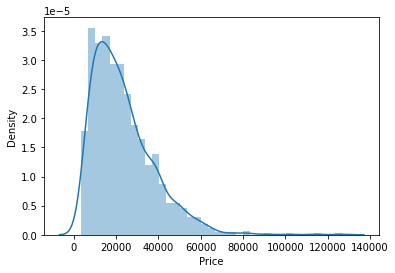

In [27]:
sns.distplot(df['Price'])

# Prediction by Pycaret

In [ ]:
!pip install --pre --no-deps pycaret

In [74]:
# case 1

features=['Ram','Weight']
#features2=['Ram','Weight','Cpu','Cpu_brand','CPU_vel','Gpu','GPU']

target=['Price']

In [ ]:
# for gdrive colab only
from pycaret.utils import enable_colab
enable_colab()

In [7]:
from pycaret.regression import *


In [75]:
data=df[features2+target]

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,6511
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 11)"
4,Train data shape,"(912, 11)"
5,Test data shape,"(391, 11)"
6,Numeric features,3
7,Categorical features,4
8,Preprocess,True
9,Imputation type,simple


In [20]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,5715.8918,68133287.7912,8109.8244,0.6565,0.3464,0.2933,0.5020
gbr,Gradient Boosting Regressor,5873.3904,73095612.8728,8427.3433,0.6352,0.3500,0.3029,0.0180
rf,Random Forest Regressor,5839.1364,73708880.7817,8476.0095,0.6313,0.3497,0.2895,0.0520
et,Extra Trees Regressor,5845.9549,76703655.0633,8622.4957,0.6131,0.3517,0.2853,0.0420
xgboost,Extreme Gradient Boosting,5842.6007,76595831.2130,8635.5663,0.6124,0.3543,0.2896,0.1730
lightgbm,Light Gradient Boosting Machine,6125.5541,80482443.5537,8839.4374,0.6064,0.3631,0.3171,0.3630
knn,K Neighbors Regressor,6153.8839,80569844.1949,8880.1549,0.6021,0.3583,0.3067,0.0100
dt,Decision Tree Regressor,6013.8049,78805674.4207,8772.3829,0.5998,0.3628,0.2938,0.0090
ada,AdaBoost Regressor,6864.5501,88332718.7145,9303.7813,0.5506,0.4150,0.4025,0.0130
lr,Linear Regression,6997.8189,94767784.5036,9578.7578,0.5307,0.4129,0.3856,0.0270


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Note
---
1. There are more than 20 models testd, awesome.
2. How many model do you know? `lr` mesns `linear regression` only, right? But it is not the best one of tested models, from the measures:
   - MAE, Mean Absolute Error
$$\text{ MSE } = \frac{1}{n}\sum_i|y_i-\hat y_i|$$   
   - MSE, Mean Square Error
$$\text{ MSE } = \frac{1}{n}\sum_i(y_i-\hat y_i)^2$$ 
3. Here suggests the best one is `catboost`, a tree-based regression.

In [21]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5739.4896,70606456.3755,8402.7648,0.7988,0.3680,0.2880
1,5122.2373,44998711.0032,6708.1079,0.6554,0.3720,0.3292
2,5682.1813,57991884.1273,7615.2403,0.5695,0.3444,0.2953
3,6689.6403,123422459.0265,11109.5661,0.4628,0.3831,0.3102
4,6950.5066,119028582.9083,10910.0221,0.4664,0.3808,0.3225
5,5836.1977,65778595.6655,8110.4005,0.7163,0.3438,0.2897
6,4985.4172,52902181.2143,7273.3886,0.8076,0.3122,0.2516
7,5303.8385,49851840.8365,7060.5836,0.7001,0.3198,0.2858
8,5447.7326,50177924.8270,7083.6378,0.6766,0.3093,0.2755


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
# Hyper tuning of the model
catboost = tune_model(catboost, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5746.0189,67164978.1154,8195.4242,0.7257,0.3761,0.3273
1,6269.8049,91001825.5040,9539.4877,0.5033,0.3682,0.3120
2,6516.3917,88234717.5315,9393.3337,0.6127,0.3521,0.3088
3,5171.0551,53087268.9952,7286.1011,0.7609,0.3205,0.2753
4,5564.7606,51750790.8935,7193.8023,0.6733,0.3327,0.2922
Mean,5853.6063,70247916.2079,8321.6298,0.6552,0.3499,0.3031
Std,484.4355,16735505.5966,999.1966,0.0909,0.0209,0.0179


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [24]:
pred_cat = predict_model(catboost)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,5899.1750,74393024.7417,8625.1391,0.6559,0.3594,0.3034


In [25]:
pred_cat

,Ram,Weight,Price,prediction_label
912,8.0,2.50,13200,20283.479942
913,12.0,2.62,37300,24025.474723
914,16.0,3.42,59900,39933.600478
915,8.0,2.06,36300,18525.612433
916,4.0,2.20,14100,10031.819511
...,...,...,...,...
1298,8.0,2.18,14800,19024.971423
1299,8.0,2.04,18400,18001.144533
1300,8.0,1.10,32300,30010.372152
1301,8.0,4.42,42500,37120.499268


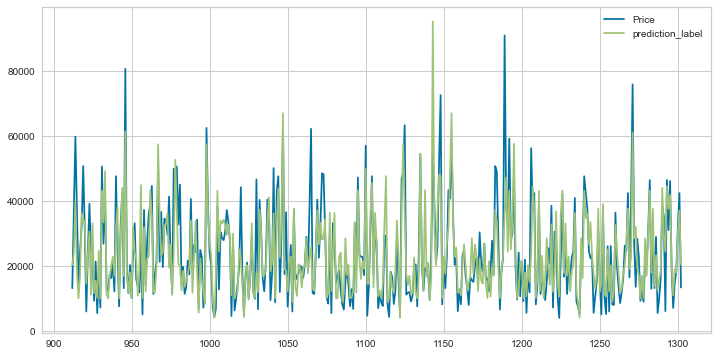

In [30]:
pred_cat[['Price','prediction_label']].plot(figsize=[12,6]);

In [33]:
#model hyperparameters
plot_model(catboost, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,RMSE
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


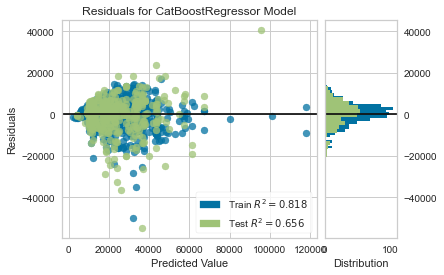

In [34]:
# Residuals Plot - the distances(error) between the actual and predicted values
plot_model(catboost, plot='residuals')

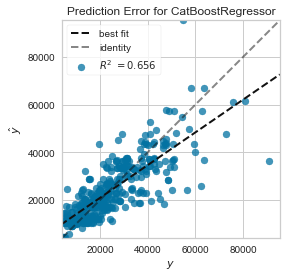

In [35]:
# Plotting the Prediction Error
plot_model(catboost, plot='error')

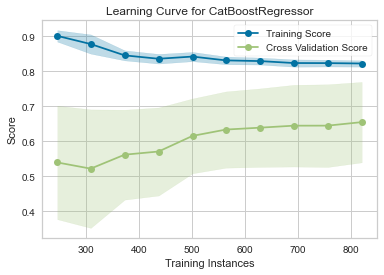

In [36]:
# Learning Curve
plot_model(catboost, plot='learning')

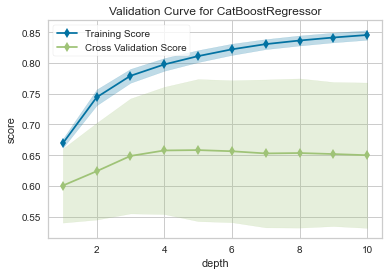

In [37]:
# Validation Curve
plot_model(catboost, plot='vc')

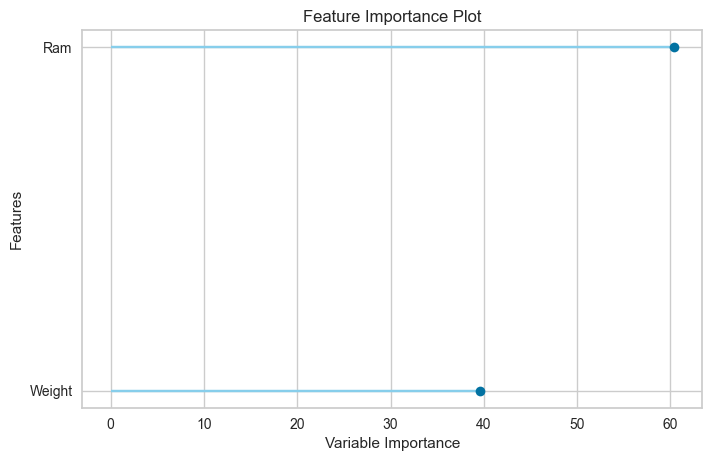

In [38]:
# Plot of Feature Importance
plot_model(catboost, plot='feature')

In [39]:
# Finalize the Model
from sklearn.model_selection import train_test_split


In [40]:
X = df[features]
Y = df[target]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [42]:
final_catboost = finalize_model(catboost)

In [43]:
final_catboost

Pipeline(memory=Memory(location=/var/folders/xb/s7vwrt4153xbxzr8hc8tbdtr0000gn/T/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Ram', 'Weight'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strategy='constant'))),
                ('low_variance',
                 TransformerWrapper(exclude=[],
                                    transformer=VarianceThreshold(threshold=0))),
                ('actual_estimator',
                 <catboost.core.CatBoostRegressor object at 0x7f9dbc9b3cd0>)])

In [44]:
new_predictions = predict_model(final_catboost, data=X_test)
new_predictions.head()

,Ram,Weight,prediction_label
0,8.0,2.50,20302.092485
1,12.0,2.62,24805.115337
2,16.0,3.42,58223.553110
3,8.0,2.06,24659.027987
4,4.0,2.20,10010.699742


In [60]:
# save transformation pipeline and model 
save_model(final_catboost, 'deployment_20221022')

Transformation Pipeline and Model Successfully Saved


(<catboost.core.CatBoostRegressor at 0x7f9dbc71aa60>,
 'deployment_20221022.pkl')

In [48]:
deployment_catboost_20221022 = load_model("deployment_20221022")

Transformation Pipeline and Model Successfully Loaded
